In [1]:
import seaborn

In [2]:
import numpy
import scipy.optimize

In [3]:
import scipy.sparse

In [4]:
import traitlets

In [5]:
import tmol.extern.py3dmol as py3dmol

In [17]:
from tmol.utility.array import coordinate_array_to_atoms, atom_array_to_coordinates

In [6]:
import tmol.io.pdb_parsing as pdb_parsing
from tmol.io.extern import fetch_pdb
from tmol.traits import Array, shape, HasTraits

In [39]:
class BondedAtomicModel(traitlets.HasTraits):
    coords = Array(dtype="f4").valid(shape[:,3])
    bonds  = traitlets.Instance(scipy.sparse.spmatrix)
    
    @traitlets.validate("bonds")
    def _valid_bonds(self, proposal):
        if proposal["value"].dtype != numpy.bool:
            raise traitlets.TraitError("dtype")
        return proposal["value"]
    
class FixedNamedAtomSystem(HasTraits):
    atoms = ["N", "CA", "C", "O"]
    bonds = [
        (("N", "CA", 0)),
        (("CA", "C", 0)),
        (("C", "O", 0)),
        (("C", "N", 1))
    ]
    
    model = traitlets.Instance(BondedAtomicModel, allow_none=True)
    
    @property
    def atom_coords(self):
        return coordinate_array_to_atoms(self.model.coords, self.atoms)
    
    def generate_bonds(self, nres):
        natoms = len(self.atoms)
        aidx = {a:i for i, a in enumerate(self.atoms)}
        
        up_entries = []
        down_entries = []
        
        for froma, toa, resoffset in self.bonds:
            assert resoffset >= 0
            up_entries.append(
                (numpy.arange(nres - resoffset) * natoms) + aidx[froma]
            )
            
            down_entries.append(
                ((numpy.arange(nres - resoffset) + resoffset) * natoms) + aidx[toa]
            )
            
        up_entries = numpy.concatenate(up_entries)
        down_entries = numpy.concatenate(down_entries)
        
        i = numpy.concatenate((up_entries, down_entries))
        j = numpy.concatenate((down_entries, up_entries))
        k = numpy.full_like(i, True, dtype=bool)
        
        return scipy.sparse.coo_matrix(
            (k, (i, j)),
            shape = (natoms * nres, natoms * nres),
        )
    
    def load_pdb(self, pdb):
        atoms = pdb_parsing.parse_pdb(pdb)
        atoms = atoms[atoms.apply(lambda r: r["atomn"] in self.atoms, axis=1)]
        for t in ("model", "chain"):
            assert atoms[t].nunique() == 1
        resi = atoms["resi"].unique()
        assert numpy.all(resi == numpy.arange(resi[0], resi[-1] + 1))
        
        atoms = atoms.set_index(["resi", "atomn"])
        
        atom_buffer = numpy.empty_like(
            resi, dtype=numpy.dtype([(n, "f4", 3) for n in self.atoms]))
        
        for i, ri in enumerate(resi):
            for a in atom_buffer.dtype.names:
                atom_buffer[i][a] = atoms.loc[ri, a][["x", "y", "z"]].values
        
        self.model = BondedAtomicModel()
        self.model.coords = atom_array_to_coordinates(atom_buffer)
        self.model.bonds = self.generate_bonds(len(atom_buffer))
        
        return self
        
                
    def to_pdb(self, b = None):
        atom_records = numpy.zeros(
            (len(self.atom_coords), len(self.atoms)),
            dtype=pdb_parsing.atom_record_dtype
        )

        atom_records["resn"] = "CEN"
        atom_records["chain"] = "X"
        atom_records["resi"] = numpy.arange(len(self.atom_coords)).reshape((-1, 1))

        for i, n in enumerate(self.atom_coords.dtype.names):
            atom_records[:,i]["atomn"] = n
            atom_records[:,i]["x"] = self.atom_coords[n][:,0]
            atom_records[:,i]["y"] = self.atom_coords[n][:,1]
            atom_records[:,i]["z"] = self.atom_coords[n][:,2]
            
        atom_records = atom_records.ravel()
        atom_records["atomi"] = numpy.arange(len(atom_records))
        if b is not None:
            atom_records["b"] = b
        
        return pdb_parsing.to_pdb(atom_records.ravel())


In [40]:
s = FixedNamedAtomSystem().load_pdb(fetch_pdb("1UBQ"))

In [42]:
print(s.to_pdb())

MODEL 
ATOM      0  N   CEN X   0      27.340  24.430   2.614  0.00  0.00
ATOM      1  CA  CEN X   0      26.266  25.413   2.842  0.00  0.00
ATOM      2  C   CEN X   0      26.913  26.639   3.531  0.00  0.00
ATOM      3  O   CEN X   0      27.886  26.463   4.263  0.00  0.00
ATOM      4  N   CEN X   1      26.335  27.770   3.258  0.00  0.00
ATOM      5  CA  CEN X   1      26.850  29.021   3.898  0.00  0.00
ATOM      6  C   CEN X   1      26.100  29.253   5.202  0.00  0.00
ATOM      7  O   CEN X   1      24.865  29.024   5.330  0.00  0.00
ATOM      8  N   CEN X   2      26.849  29.656   6.217  0.00  0.00
ATOM      9  CA  CEN X   2      26.235  30.058   7.497  0.00  0.00
ATOM     10  C   CEN X   2      26.882  31.428   7.862  0.00  0.00
ATOM     11  O   CEN X   2      27.906  31.711   7.264  0.00  0.00
ATOM     12  N   CEN X   3      26.214  32.097   8.771  0.00  0.00
ATOM     13  CA  CEN X   3      26.772  33.436   9.197  0.00  0.00
ATOM     14  C   CEN X   3      27.151  33.362  10.650 

In [68]:
import scipy.sparse.csgraph as csgraph

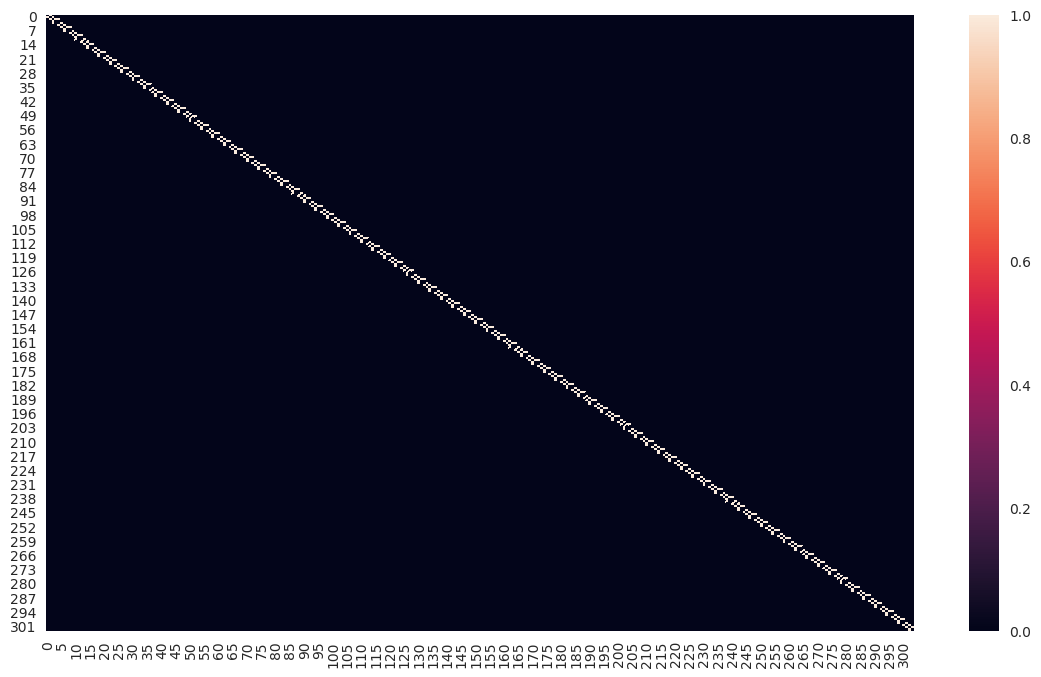

In [69]:
seaborn.heatmap(s.model.bonds.todense())

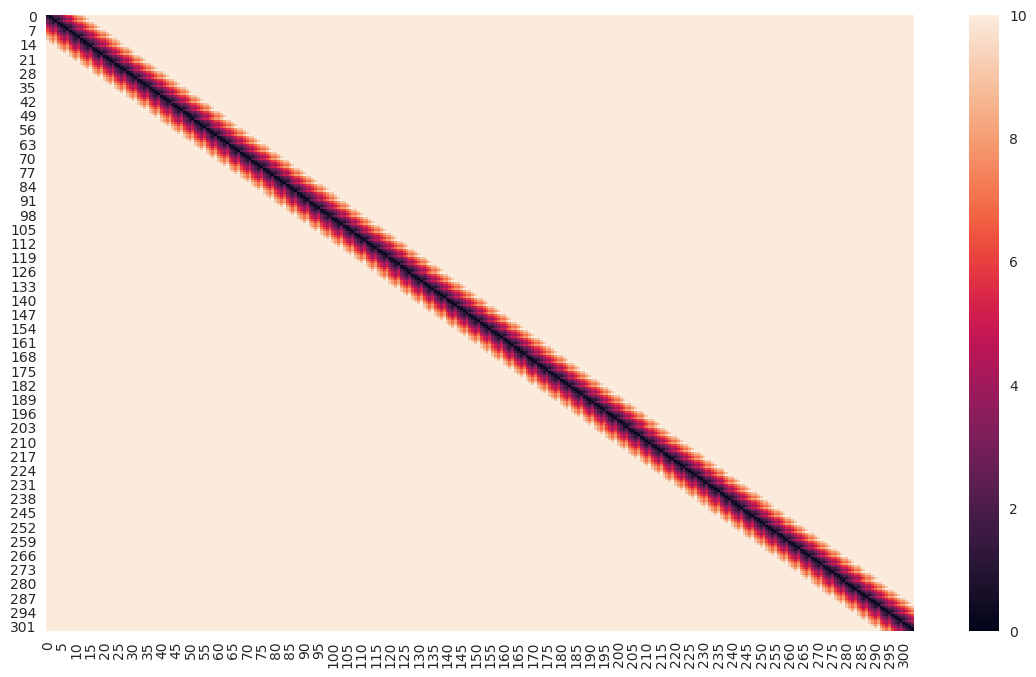

In [70]:
seaborn.heatmap(
    csgraph.shortest_path(s.model.bonds, directed=False, unweighted=True),
    vmax=10
)

In [78]:
import torch
import torch.autograd

In [152]:
class StupidLJScore(traitlets.HasTraits):
    r_m = traitlets.Float(1.0)
    epsilon = traitlets.Float(1.0)
    bonds   = traitlets.Instance(scipy.sparse.spmatrix)
    
    def setup(self):
        # ~10 slower on <1000 atoms, depth-limited is much better on larger systems
        self.bonded_path_length = torch.autograd.Variable(torch.Tensor(
            csgraph.shortest_path(
                self.bonds,
                directed=False,
                unweighted=True
            )),
            requires_grad = False
        )
        
        # ~10 slower on <1000 atoms, depth-limited is much better on larger systems
        self.lj_interaction_weight = (self.bonded_path_length > 3).float()
        
        return self
    
    def score(self, coords):
        self.coords = torch.autograd.Variable(torch.Tensor(coords), requires_grad=True)
        
        ind = torch.autograd.Variable(torch.Tensor(numpy.arange(self.coords.shape[0])), requires_grad=False)

        ind_a = ind.view((-1, 1))
        ind_b = ind.view((1, -1))
        
        deltas = self.coords.view((-1, 1, 3)) - self.coords.view((1, -1, 3))

        dist = torch.norm(deltas, 2, -1)

        fd = (self.r_m / dist)
        fd2 = fd * fd
        fd6 = fd2 * fd2 * fd2
        fd12 = fd6 * fd6
        
        self.raw_lj = torch.where(
            ind_a != ind_b,
            self.epsilon * (fd12  - 3 * fd6),
            torch.autograd.Variable(torch.Tensor([0.0]), requires_grad=False)
        )


        self.lj = self.raw_lj * self.lj_interaction_weight
        
        self.atom_scores = torch.sum(self.lj.detach(), dim=-1)
        self.total_score = torch.sum(self.lj)
        
        (self.grads,) = torch.autograd.grad(self.total_score, self.coords)
        
        return self

In [153]:
scr = StupidLJScore(bonds = s.model.bonds).setup()
scr.score(s.model.coords)

/home/fordas/.conda/envs/tmol/lib/python3.5/site-packages/scipy/sparse/compressed.py:225: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  " != instead.", SparseEfficiencyWarning)


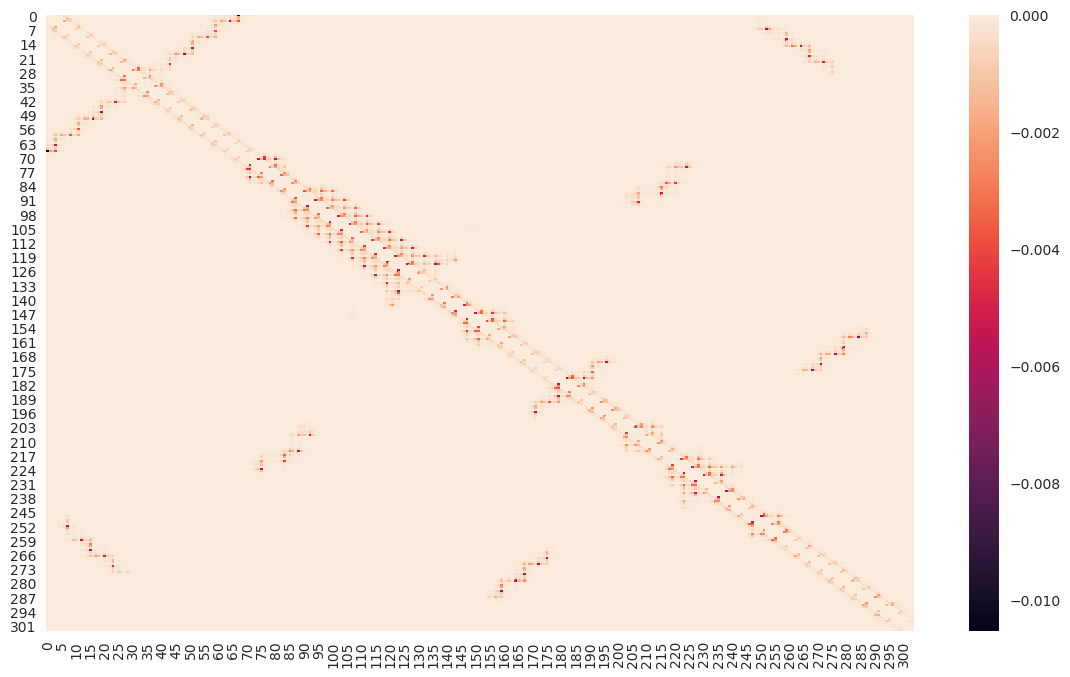

In [154]:
seaborn.heatmap(scr.lj.detach().numpy())

In [186]:
class StupidMinimizer:
    def __init__(self, system, scorefn):
        self.system = system
        self.scorefn = scorefn
        
    def fun(self, x):
        coords = x.reshape(self.system.coords.shape)
        
        score = self.scorefn.score(coords)
        return (
            score.total_score.detach().numpy(),
            score.grads.numpy().reshape(-1)
        )
    
    def update_system(self, x):
        self.system.coords = x.reshape(self.system.coords.shape)
    
    def minimize(self):
        self.result = scipy.optimize.minimize(
            self.fun,
            self.system.coords.reshape(-1),
            jac=True,
            tol=1,
            options = dict(disp=False, maxiter=250),
            callback=self.update_system
        )
        
        return self

In [187]:
class PDBTrajectoryViewer(object):
    def __init__(self, target, score=None):
        self.target = target
        self.view = py3dmol.view(1200, 600)
        
        self.target.observe(lambda c: self.add_frame(), "state")
        self.score = score
        
        self.pdbs = []
        
    def add_frame(self):
        self.pdbs.append(self.target.traits()["state"].to_pdb(
            self.target.state,
            b= self.score(self.target.coords).atom_scores.numpy() if self.score else None))
        
        self.view.addModel(self.pdb, "pdb")
        if self.score:
            self.view.setStyle({"sphere" : {"colorscheme" : {"prop":'b',"gradient": 'rwb',"min":1,"max":-1}}})
        else:
            self.view.setStyle({"sphere" : {}})
        
    def display(self):
        self.view.clear()
        
        self.view.zoomTo()
        display(self.view.update())
        
     
    
class PDBModelViewer(object):
    def __init__(self, target, score=None):
        self.target = target
        self.view = py3dmol.view(1200, 600)
        
        self.target.model.observe(lambda c: self.update(), "coords")
        self.score = score
        
        self.pdb = None
        
        self.update()
        self.view.zoomTo()
        self.update()
    
    def update(self):
        self.view.clear()
        self.pdb = self.target.to_pdb(
            b = self.score.score(self.target.model.coords).atom_scores.numpy() if self.score else None)
        self.view.addModel(self.pdb, "pdb")
        if self.score:
            self.view.setStyle({"sphere" : {"colorscheme" : {"prop":'b',"gradient": 'rwb',"min":1,"max":-1}}})
        else:
            self.view.setStyle({"sphere" : {}})
        
        display(self.view.update())


In [194]:
system = FixedNamedAtomSystem().load_pdb(fetch_pdb("1ubq"))
score = StupidLJScore(bonds=system.model.bonds).setup()

/home/fordas/.conda/envs/tmol/lib/python3.5/site-packages/scipy/sparse/compressed.py:225: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  " != instead.", SparseEfficiencyWarning)


In [195]:
score.score(system.model.coords)

In [196]:
score.total_score

Variable containing:
-3.0266
[torch.FloatTensor of size ()]

In [197]:
system = FixedNamedAtomSystem().load_pdb(fetch_pdb("1ubq"))
score = StupidLJScore(bonds=system.model.bonds).setup()

system_view = PDBModelViewer(system, StupidLJScore(bonds=system.model.bonds, r_m=2).setup())
system_view

/home/fordas/.conda/envs/tmol/lib/python3.5/site-packages/scipy/sparse/compressed.py:225: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  " != instead.", SparseEfficiencyWarning)


In [198]:
test_model = FixedNamedAtomSystem().load_pdb(fetch_pdb("1UBQ"))
test_score = StupidLJScore(r_m=3, bonds=test_model.model.bonds).setup()

with torch.autograd.profiler.profile() as prof:
    test_score.score(test_model.model.coords)
print(prof)

view = PDBModelViewer(test_model, test_score)

/home/fordas/.conda/envs/tmol/lib/python3.5/site-packages/scipy/sparse/compressed.py:225: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  " != instead.", SparseEfficiencyWarning)


-------------------------------  ---------------  ---------------  ---------------  ---------------  ---------------
Name                                    CPU time        CUDA time            Calls        CPU total       CUDA total
-------------------------------  ---------------  ---------------  ---------------  ---------------  ---------------
view                                     9.525us          0.000us                1          9.525us          0.000us
view                                     2.032us          0.000us                1          2.032us          0.000us
view                                     8.606us          0.000us                1          8.606us          0.000us
view                                     2.829us          0.000us                1          2.829us          0.000us
expand                                   5.301us          0.000us                1          5.301us          0.000us
expand                                   2.048us          0.000u

In [199]:
StupidMinimizer(test_model.model, test_score).minimize()